In [ ]:
# ONS (Census 2011) statistics for Lewisham.
# Fetches Nomis data releases and prepares them for use in Lewisham ward profiles.
#
# This requires the OA->LSOA lookup table produced by "lbl_boundaries_oa.ipynb"
# as well as the OA->WD22 lookup table produced by "lbl_boundaries_2022_wards.ipynb"

In [1]:
%%capture
!pip install geopandas mapclassify

In [2]:
from google.colab import drive

In [4]:
import google.colab.files as files

In [3]:
import pandas as pd
import IPython
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd

Tools
==
Helpers to reformat & aggregate the Nomis source data.

In [5]:
# Extract the subset we need.
def filter_nomis_data(d, date_values, geography_values):
  return d[d.date.isin(date_values) & 
           d.geography.isin(geography_values)]

# Reformat Nomis data into a lookup table format:
# clear labelling of the index (geography) column, 
# remove superfluous columns.
def format_nomis_data(d, geo_colname='OA11CD'):
  return d.\
           rename(columns={'geography code': geo_colname}).\
           drop(columns=['date', 'geography'])

# Convenience function to call the above.
def nomis_to_oa(d, years, oa_list):
  return format_nomis_data(filter_nomis_data(d, years, oa_list))

In [6]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, oa_group_table, oa_col, group_col):
  return pd.merge(oa_group_table, oa_data, on=oa_col, how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()

Data
==
GDrive mount
--

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# Used as root folder for google
project_dir = '/content/gdrive/MyDrive/WardProfiles'

In [9]:
# # Used as root folder for local
# project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

In [10]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

# For exports
output_dir = f"{project_dir}/educational_attainment"

In [ ]:
!mkdir -p '{output_dir}'

In [ ]:
!ls '{output_dir}'

lbl_educational_attainment_lsoa11.csv lbl_oa11_educational_attainment.pdf
lbl_educational_attainment_oa11.csv   lbl_oa11_educational_attainment.png
lbl_educational_attainment_wd22.csv


Downloads
--

This dataset provides 2011 estimates that classify usual residents aged 16 and over in England and Wales by their highest level of qualification. The estimates are as at census day, 27 March 2011.
This information identifies educational achievement across the population to help government resource allocation and policy making, especially in relation to disadvantaged population groups and educationally deprived areas.
Similar estimates from the 2001 Census were provided in table UV24 however the category "Apprenticeship" is identified separately in 2011 estimates to provide more detail.
For more information about qualifications please see Part 4 of the 2011 Census User Guide at http://www.ons.gov.uk/ons/guide-method/census/2011/census-data/2011-census-user-guide/information-by-variable/index.html


In [ ]:
# Educational attainment (detailed), OAs in London 2011
# Source: 
# https://www.nomisweb.co.uk/census/2011/qs501ew
!curl 'https://www.nomisweb.co.uk/api/v01/dataset/nm_554_1.bulk.csv?time=latest&measures=20100&geography=1254112598...1254113437,1254258305,1254258306,1254258319,1254265357...1254265363,1254265589...1254265605,1254265661...1254265680,2092957699,2013265927&rural_urban=0&cell=0...7' \
  --output "{output_dir}/census11_educational_attainment_oa11_london.csv"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56886  100 56886    0     0  19121      0  0:00:02  0:00:02 --:--:-- 19147


Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [11]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [12]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

Absolute numbers
--

In [15]:
# For filtering of source data
lbl_oa_list = oa_lsoa_join.OA11CD.unique() # All OAs in Lewisham
years = [2011] # Just a precaution, in case any of the downloads include multiple periods

for datname in ['educational_attainment']:
  IPython.display.display(f"=== {datname} ===")
  # Load the Nomis data
  d = pd.read_csv(f"{output_dir}/census11_{datname}_oa11_london.csv")

  # Simplify the column names
  d.columns = d.columns.str.replace(
      # Remove the redundant title prefix and qualifier suffix
      r'^.*?: (.*?); measures: Value', 
      r'\1')
  d = d.rename(columns={'All categories: Highest level of qualification': 'Total'})

  # Drop unused columns
  if 'Rural Urban' in d.columns:
    d.drop(columns='Rural Urban', inplace=True) # Lewisham is all urban

  # Transform to OA index data
  lbl_oa = nomis_to_oa(d, years, lbl_oa_list)
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(lbl_oa, oa_lsoa_join, oa_col='OA11CD', group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level
  lbl_wd22 = aggregate_oa_groups(lbl_oa, oa_wd22_join, oa_col='OA11CD', group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Reference geographies
  refs = d[d.geography.isin(['Lewisham', 'London', 'England'])]
  refs = refs.rename(columns={'geography': 'Name', 'geography code': 'Code'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.tail())
  

'=== educational_attainment ==='

,OA11CD,Total,No qualifications,Level 1 qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications and above,Other qualifications
0,E00016112,236,56,32,29,1,26,79,13
1,E00016113,297,102,47,36,6,32,50,24
2,E00016114,212,48,31,36,2,19,58,18
3,E00016115,233,73,38,37,4,23,43,15
4,E00016116,245,24,29,32,2,27,100,31


,Total,No qualifications,Level 1 qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications and above,Other qualifications
LSOA11CD,,,,,,,,
E01003189,1194,373,164,193,16,115,240,93
E01003190,1336,287,211,196,16,133,321,172
E01003191,1101,249,212,197,22,91,240,90
E01003192,1237,345,203,188,26,117,240,118
E01003193,1240,312,172,169,30,137,332,88


,Total,No qualifications,Level 1 qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications and above,Other qualifications
WD22CD_proposed,,,,,,,,
E05013714,7801,2099,1249,1198,136,785,1653,681
E05013715,12669,1764,954,1324,119,1104,6510,894
E05013716,14138,1576,1123,1379,104,1925,6819,1212
E05013717,12630,2493,1740,1870,247,1365,3888,1027
E05013718,12019,1834,1143,1400,157,1242,5418,825


,date,Name,Code,Total,No qualifications,Level 1 qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications and above,Other qualifications
887,2011,England,E92000001,42989620,9656810,5714441,6544614,1532934,5309631,11769361,2461829
888,2011,London,E12000007,6549173,1152517,702687,775928,107665,685508,2470225,654643


Population normalised
--

In [ ]:
for geog, geog_colname in zip(['oa11', 'wd22'], ['OA11CD', 'WD22CD_proposed']):
  IPython.display.display(f"=== {geog} ===")

  ea = pd.read_csv(f"{output_dir}/lbl_educational_attainment_{geog}.csv")

  # Relative measures
  d = ea[[geog_colname]].copy()
  var_colnames = ea.drop(columns=[geog_colname, 'Total']).columns
  for colname in var_colnames: 
    d[colname] = ea[colname] * 100. / ea.Total
  
  d.to_csv(f"{output_dir}/lbl_educational_attainment_share_{geog}.csv", index=False)
  IPython.display.display(d.head())

'=== oa11 ==='

,OA11CD,No qualifications,Level 1 qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications and above,Other qualifications
0,E00016112,23.728814,13.559322,12.288136,0.423729,11.016949,33.474576,5.508475
1,E00016113,34.343434,15.824916,12.121212,2.020202,10.774411,16.835017,8.080808
2,E00016114,22.641509,14.622642,16.981132,0.943396,8.962264,27.358491,8.490566
3,E00016115,31.330472,16.309013,15.879828,1.716738,9.871245,18.454936,6.437768
4,E00016116,9.795918,11.836735,13.061224,0.816327,11.020408,40.816327,12.653061


'=== wd22 ==='

,WD22CD_proposed,No qualifications,Level 1 qualifications,Level 2 qualifications,Apprenticeship,Level 3 qualifications,Level 4 qualifications and above,Other qualifications
0,E05013714,26.906807,16.010768,15.357006,1.743366,10.062812,21.189591,8.729650
1,E05013715,13.923751,7.530192,10.450706,0.939301,8.714184,51.385271,7.056595
2,E05013716,11.147263,7.943132,9.753855,0.735606,13.615787,48.231716,8.572641
3,E05013717,19.738717,13.776722,14.806017,1.955661,10.807601,30.783848,8.131433
4,E05013718,15.259173,9.509943,11.648224,1.306265,10.333638,45.078626,6.864132


# Spatial

In [ ]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [ ]:
lbl_oa = pd.read_csv(f"{output_dir}/lbl_educational_attainment_share_oa11.csv")
education_oa_geom = oa11.merge(lbl_oa, on='OA11CD')

No handles with labels found to put in legend.


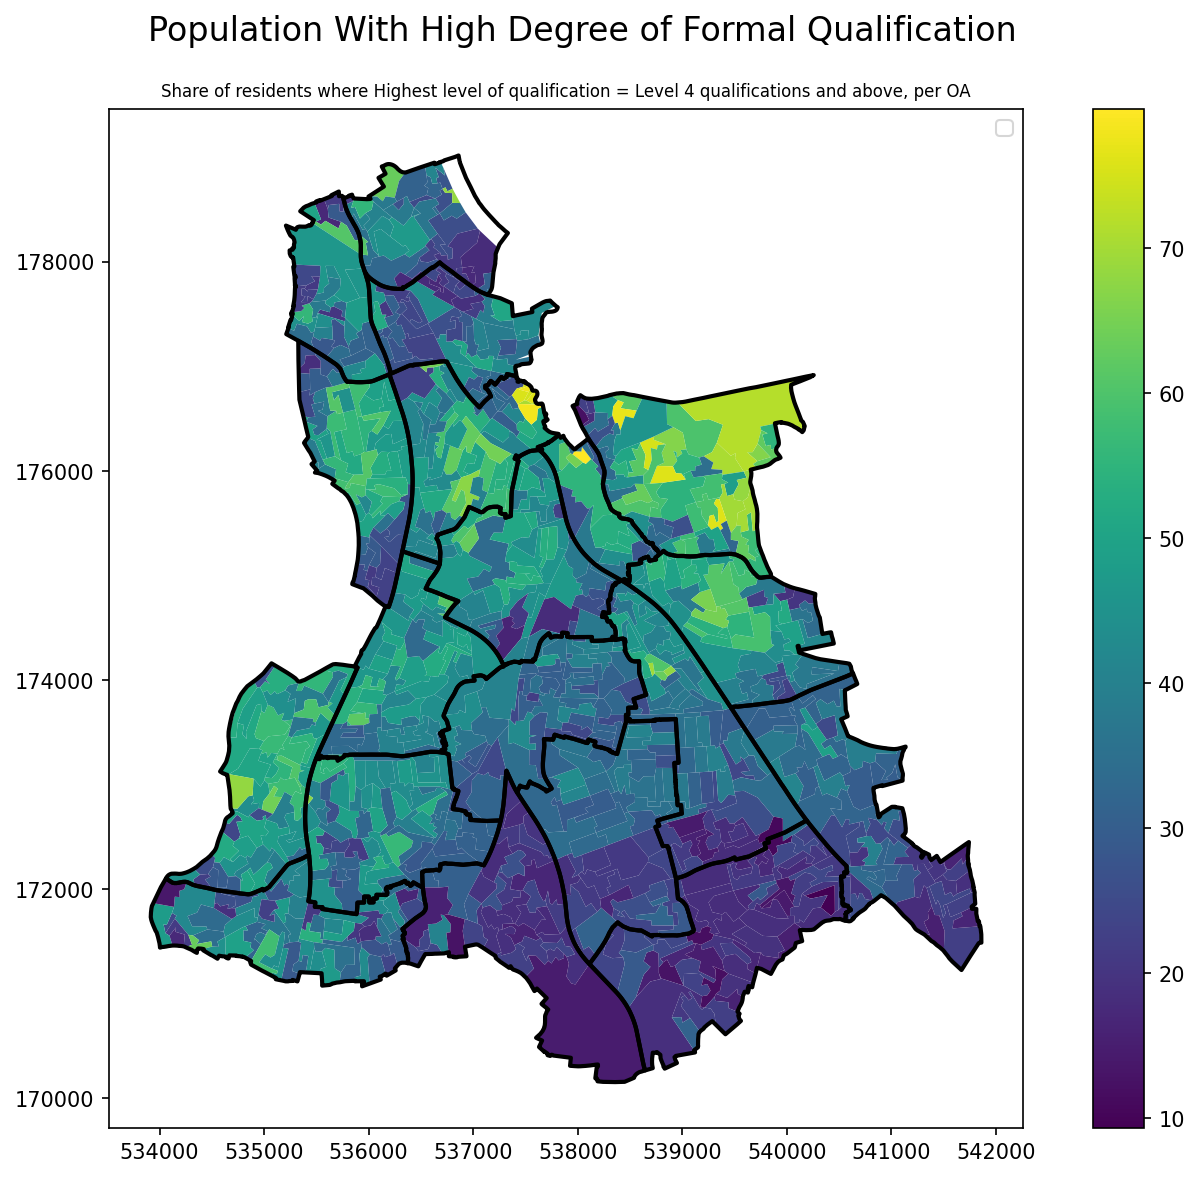

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Population With High Degree of Formal Qualification', fontsize=16, y=.95)
plt.title('Share of residents where Highest level of qualification = Level 4 qualifications and above, per OA', fontsize=8)
education_oa_geom.plot(ax=ax, column="Level 4 qualifications and above", legend=True) 
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

# plt.savefig(f"{output_dir}/lbl_oa11_educational_attainment.png", dpi=600)
# plt.savefig(f"{output_dir}/lbl_oa11_educational_attainment.pdf")

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Population Without Formal Qualification', fontsize=16, y=.95)
plt.title('Share of residents where Highest level of qualification = No qualifications, per OA', fontsize=8)
education_oa_geom.plot(ax=ax, column="No qualifications", legend=True) 
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

# plt.savefig(f"{output_dir}/lbl_oa11_educational_attainment.png", dpi=600)
# plt.savefig(f"{output_dir}/lbl_oa11_educational_attainment.pdf")